In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

torch.manual_seed(1)

In [4]:
## Data Preprocessing

# データの読み込み
eps = pd.read_csv("annualEPS.csv", index_col=1)
eps = eps.drop('Unnamed: 0', axis=1)
eps = eps.T # 転置して時間をaxis=1に
eps = eps.iloc[::-1] # 時間を上から順に
eps.index = np.linspace(-29, 0, 30).astype(int)

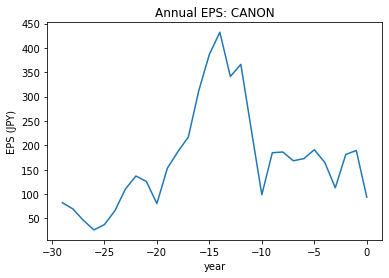

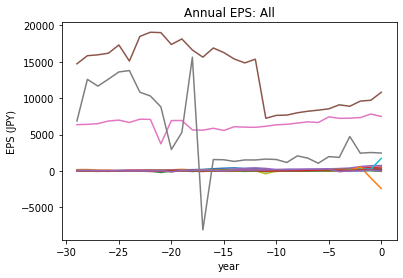

In [3]:
# データのプロット
fig = plt.figure()
ax = fig.add_subplot()
plt.title('Annual EPS: CANON')
plt.ylabel('EPS (JPY)')
plt.xlabel('year')
plt.plot(eps['CANON INCORPORATED'])
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
plt.title('Annual EPS: All')
plt.ylabel('EPS (JPY)')
plt.xlabel('year')
plt.plot(eps)
plt.show()

all_data = eps['CANON INCORPORATED']

In [11]:
# 標準化(minmax)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
all_normalized = scaler.fit_transform(all_data.values.reshape(-1, 1)) # expect 2D array

# Torch.Tensorに変換
all_normalized = torch.Tensor(all_normalized).view(-1)

In [19]:
all_normalized

tensor([-0.7249, -0.7879, -0.9034, -1.0000, -0.9463, -0.8061, -0.5866, -0.4548,
        -0.5099, -0.7333, -0.3756, -0.2087, -0.0593,  0.4117,  0.7756,  1.0000,
         0.5528,  0.6746,  0.0121, -0.6440, -0.2191, -0.2116, -0.3005, -0.2786,
        -0.1888, -0.3166, -0.5737, -0.2364, -0.1963, -0.6681])

In [13]:
# tuple で inout sequence 作成 (training window 指定、サンプルサイズは len(input_data)-tw に減る)
def create_inout_sequence(input_data, tw):
    inout_seq = []
    for i in range(len(input_data)-tw):
        train_seq = input_data[i: i+tw]
        train_label = input_data[i+tw: i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 5
all_inout_seq = create_inout_sequence(all_normalized, train_window)

In [31]:
all_inout_seq

[(tensor([-0.7249, -0.7879, -0.9034, -1.0000, -0.9463]), tensor([-0.8061])),
 (tensor([-0.7879, -0.9034, -1.0000, -0.9463, -0.8061]), tensor([-0.5866])),
 (tensor([-0.9034, -1.0000, -0.9463, -0.8061, -0.5866]), tensor([-0.4548])),
 (tensor([-1.0000, -0.9463, -0.8061, -0.5866, -0.4548]), tensor([-0.5099])),
 (tensor([-0.9463, -0.8061, -0.5866, -0.4548, -0.5099]), tensor([-0.7333])),
 (tensor([-0.8061, -0.5866, -0.4548, -0.5099, -0.7333]), tensor([-0.3756])),
 (tensor([-0.5866, -0.4548, -0.5099, -0.7333, -0.3756]), tensor([-0.2087])),
 (tensor([-0.4548, -0.5099, -0.7333, -0.3756, -0.2087]), tensor([-0.0593])),
 (tensor([-0.5099, -0.7333, -0.3756, -0.2087, -0.0593]), tensor([0.4117])),
 (tensor([-0.7333, -0.3756, -0.2087, -0.0593,  0.4117]), tensor([0.7756])),
 (tensor([-0.3756, -0.2087, -0.0593,  0.4117,  0.7756]), tensor([1.])),
 (tensor([-0.2087, -0.0593,  0.4117,  0.7756,  1.0000]), tensor([0.5528])),
 (tensor([-0.0593,  0.4117,  0.7756,  1.0000,  0.5528]), tensor([0.6746])),
 (tensor

In [29]:
# 訓練データとテストデータに分割
# -29 ~ -5: train, -4 ~ 0: test
train_inout_seq = all_inout_seq[: -5]
test_inout_seq = all_inout_seq[-5: ]

In [30]:
train_inout_seq

[(tensor([-0.7249, -0.7879, -0.9034, -1.0000, -0.9463]), tensor([-0.8061])),
 (tensor([-0.7879, -0.9034, -1.0000, -0.9463, -0.8061]), tensor([-0.5866])),
 (tensor([-0.9034, -1.0000, -0.9463, -0.8061, -0.5866]), tensor([-0.4548])),
 (tensor([-1.0000, -0.9463, -0.8061, -0.5866, -0.4548]), tensor([-0.5099])),
 (tensor([-0.9463, -0.8061, -0.5866, -0.4548, -0.5099]), tensor([-0.7333])),
 (tensor([-0.8061, -0.5866, -0.4548, -0.5099, -0.7333]), tensor([-0.3756])),
 (tensor([-0.5866, -0.4548, -0.5099, -0.7333, -0.3756]), tensor([-0.2087])),
 (tensor([-0.4548, -0.5099, -0.7333, -0.3756, -0.2087]), tensor([-0.0593])),
 (tensor([-0.5099, -0.7333, -0.3756, -0.2087, -0.0593]), tensor([0.4117])),
 (tensor([-0.7333, -0.3756, -0.2087, -0.0593,  0.4117]), tensor([0.7756])),
 (tensor([-0.3756, -0.2087, -0.0593,  0.4117,  0.7756]), tensor([1.])),
 (tensor([-0.2087, -0.0593,  0.4117,  0.7756,  1.0000]), tensor([0.5528])),
 (tensor([-0.0593,  0.4117,  0.7756,  1.0000,  0.5528]), tensor([0.6746])),
 (tensor

In [32]:
test_inout_seq

[(tensor([-0.2191, -0.2116, -0.3005, -0.2786, -0.1888]), tensor([-0.3166])),
 (tensor([-0.2116, -0.3005, -0.2786, -0.1888, -0.3166]), tensor([-0.5737])),
 (tensor([-0.3005, -0.2786, -0.1888, -0.3166, -0.5737]), tensor([-0.2364])),
 (tensor([-0.2786, -0.1888, -0.3166, -0.5737, -0.2364]), tensor([-0.1963])),
 (tensor([-0.1888, -0.3166, -0.5737, -0.2364, -0.1963]), tensor([-0.6681]))]

In [33]:
## Creating LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        # LSTMは3つのインプットがある[previous hidden state, previous cell state, current input]
        # self.hidden_cellで[previous hidden state, previous cell state]を記憶しておく?
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size) # input_size: 入力次元, hidden_size: 隠れ層の次元
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                           torch.zeros(1, 1, self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [38]:
# make an LSTM() class object
model = LSTM()
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [40]:
# define a loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # ここではAdam

In [41]:
## Training the Model
epochs = 1000 # 変えてもよい

for i in range(epochs):
    for seq, labels in train_inout_seq:
        # いろいろ0に初期化
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00945380
epoch:  26 loss: 0.06109355
epoch:  51 loss: 0.04428512
epoch:  76 loss: 0.03038828
epoch: 101 loss: 0.00714393
epoch: 126 loss: 0.02337206
epoch: 151 loss: 0.00442312
epoch: 176 loss: 0.01088984
epoch: 201 loss: 0.01582474
epoch: 226 loss: 0.00431881
epoch: 251 loss: 0.00443249
epoch: 276 loss: 0.00750541
epoch: 301 loss: 0.00450920
epoch: 326 loss: 0.00503246
epoch: 351 loss: 0.00000267
epoch: 376 loss: 0.00597631
epoch: 401 loss: 0.00250504
epoch: 426 loss: 0.00036860
epoch: 451 loss: 0.00047213
epoch: 476 loss: 0.00019790
epoch: 501 loss: 0.00000720
epoch: 526 loss: 0.00502104
epoch: 551 loss: 0.00198414
epoch: 576 loss: 0.00663665
epoch: 601 loss: 0.00038922
epoch: 626 loss: 0.00000610
epoch: 651 loss: 0.00081705
epoch: 676 loss: 0.00020131
epoch: 701 loss: 0.00002324
epoch: 726 loss: 0.00021199
epoch: 751 loss: 0.00526590
epoch: 776 loss: 0.00000280
epoch: 801 loss: 0.00001339
epoch: 826 loss: 0.00002540
epoch: 851 loss: 0.00033336
epoch: 876 loss: 0.0

In [ ]:
# # Save the trained model
# PATH = './lstm.pth'
# torch.save(model.state_dict(), PATH)

# # Load the trained model
# model = LSTM()
# model.load_state_dict(torch.load(PATH))

84.00881839144763


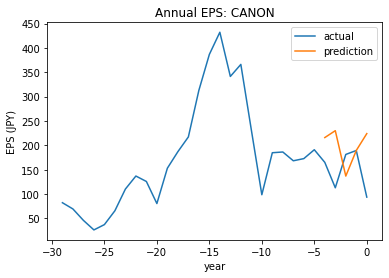

In [42]:
## Making Predictions

# testをXとtに分割
test_X = []
test_label = []
for x, t in test_inout_seq:
    test_X.append(x)
    test_label.append(t)

# prediction loop
model.eval()

pred = []
for i in test_X:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred.append(model(i).item())

# convert normalized values to actual values
actual_pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))

# 二乗平均平方根誤差 (RMSE: Root Mean Squared Error)で評価
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(eps['CANON INCORPORATED'][-5:].values, actual_pred.reshape(len(actual_pred)))
rmse = np.sqrt(mse)
print(rmse)

# plot
fig = plt.figure()
ax = fig.add_subplot()

plt.plot(eps['CANON INCORPORATED'], label='actual') # all data
x_axis = np.linspace(-29, 0, 30).astype(int)
plt.plot(x_axis[-5:], actual_pred, label='prediction')

plt.title('Annual EPS: CANON')
plt.ylabel('EPS (JPY)')
plt.xlabel('year')
plt.legend()

plt.show()